## Libraries

In [1]:
import sys
print(sys.version)

3.10.10 (tags/v3.10.10:aad5f6a, Feb  7 2023, 17:20:36) [MSC v.1929 64 bit (AMD64)]


In [2]:
!python3.9 -m pip list

Package                   Version              Build
------------------------- -------------------- -----
accelerate                1.8.1
aiohappyeyeballs          2.6.1
aiohttp                   3.12.13
aiosignal                 1.3.2
alembic                   1.14.0
annotated-types           0.7.0
anyio                     4.9.0
APScheduler               3.11.0
argon2-cffi               21.3.0
argon2-cffi-bindings      21.2.0
arrow                     1.2.3
asttokens                 2.2.1
async-lru                 2.0.4
async-timeout             5.0.1
asyncer                   0.0.8
attrs                     25.3.0
Automat                   0.8.0
Babel                     2.11.0
backcall                  0.2.0
backoff                   2.2.1
beautifulsoup4            4.11.1
bleach                    5.0.1
blinker                   1.4
cachetools                5.5.0
certifi                   2025.6.15
cffi                      1.15.1
chardet                   3.0.4
charset-normalizer

tqdm                      4.67.1
traitlets                 5.8.0
transformers              4.53.0
triton                    3.3.1
Twisted                   18.9.0
typer                     0.15.1
types-python-dateutil     2.9.0.20241206
typing_extensions         4.14.0
typing-inspection         0.4.1
tzdata                    2024.2
tzlocal                   5.2
ubuntu-pro-client         8001
ufw                       0.36
ujson                     5.10.0
unattended-upgrades       0.1
uri-template              1.2.0
urllib3                   2.5.0
uvicorn                   0.22.0
uvloop                    0.21.0
wadllib                   1.3.3
watchfiles                1.0.3
wcwidth                   0.2.5
webcolors                 1.12
webencodings              0.5.1
websocket-client          1.4.2
websockets                14.1
wheel                     0.34.2
widgetsnbextension        4.0.4
xxhash                    3.1.0
yarl                      1.20.1
zipp                      3.

### Setup

In [3]:
!rm -rf sample_data

In [2]:
API_KEY= 'anonimizado'

In [3]:
import dspy
from sentence_transformers import SentenceTransformer
from peft import PeftModel

ModuleNotFoundError: No module named 'sentence_transformers'

In [6]:
!python3.9 -m pip show dspy

Name: dspy
Version: 2.5.43
Summary: DSPy
Home-page: https://github.com/stanfordnlp/dsp
Author: Omar Khattab
Author-email: okhattab@stanford.edu
License: MIT License
Location: /home/mmendoza/.local/lib/python3.9/site-packages
Requires: anyio, asyncer, backoff, cachetools, cloudpickle, datasets, diskcache, httpx, jinja2, joblib, json-repair, litellm, magicattr, openai, optuna, pandas, pydantic, regex, requests, tenacity, tqdm, ujson
Required-by: 


In [7]:
!python3.9 -m pip show peft

Name: peft
Version: 0.15.2
Summary: Parameter-Efficient Fine-Tuning (PEFT)
Home-page: https://github.com/huggingface/peft
Author: The HuggingFace team
Author-email: benjamin@huggingface.co
License: Apache
Location: /home/mmendoza/.local/lib/python3.9/site-packages
Requires: accelerate, huggingface_hub, numpy, packaging, psutil, pyyaml, safetensors, torch, tqdm, transformers
Required-by: 


In [8]:
!python3.9 -m pip show sentence_transformers

Name: sentence-transformers
Version: 4.1.0
Summary: Embeddings, Retrieval, and Reranking
Home-page: https://www.SBERT.net
Author: 
Author-email: Nils Reimers <info@nils-reimers.de>, Tom Aarsen <tom.aarsen@huggingface.co>
License: Apache 2.0
Location: /home/mmendoza/.local/lib/python3.9/site-packages
Requires: huggingface-hub, Pillow, scikit-learn, scipy, torch, tqdm, transformers, typing_extensions
Required-by: 


## Debate

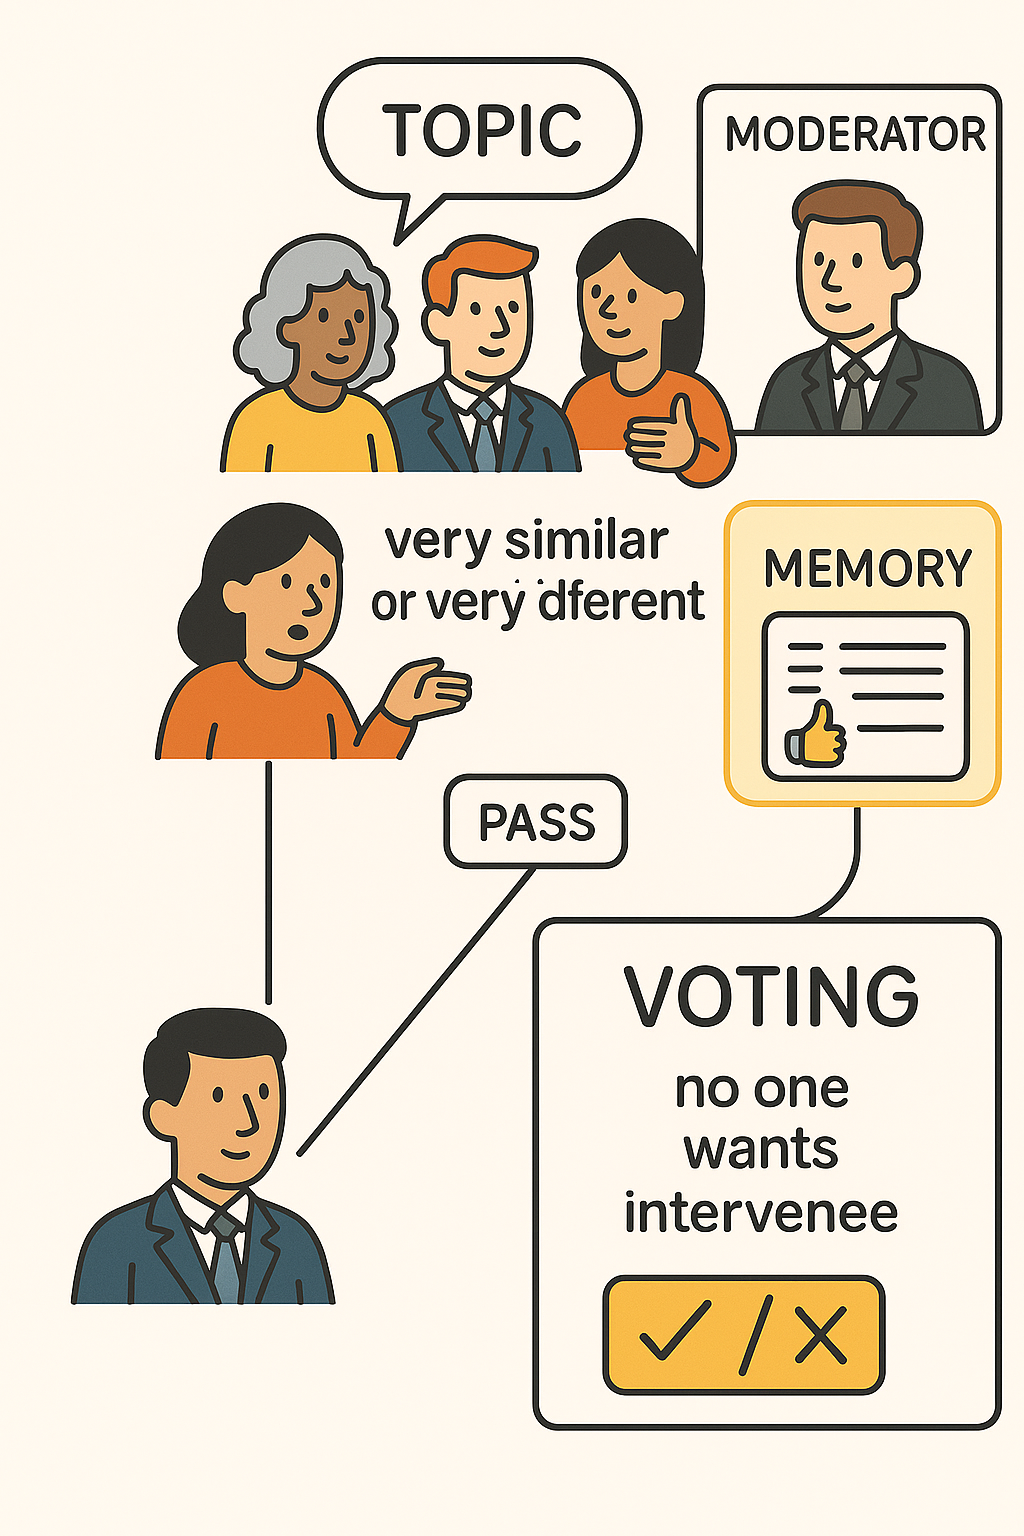

In [9]:
from IPython.display import Image, display

display(Image(filename='debate.png', width=400))

In [10]:
def embedding_init():
  sbert = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
  sbert[0].auto_model = PeftModel.from_pretrained(sbert[0].auto_model, "vahidthegreat/StanceAware-SBERT")
  return sbert



def similarity_score(sbert,sentences):
  embed1 = sbert.encode(sentences[0])
  embed2 = sbert.encode(sentences[1])
  return sbert.similarity(embed1,embed2).numpy()[0][0]


sbert = embedding_init()

### Data Input

In [11]:
def split_profiles(file_path):
    with open(file_path, 'r') as file:
        data = file.read()

    # Split the profiles based on '$.'
    profiles = data.split('$.')

    # Remove any empty strings or leading/trailing whitespace
    profiles = [profile.strip() for profile in profiles if profile.strip()]

    return profiles


In [12]:
profiles = split_profiles('Politicians_profiles.txt')

with open('./Discussion Topic.txt', 'r') as file:
    topic = file.read()

In [13]:
lm = dspy.LM('openai/gpt-4o-mini', api_key = API_KEY)

dspy.settings.configure(cache= False)

dspy.configure(lm=lm)

### Agentes

In [14]:
from collections import deque

class FixedMemory:
    def __init__(self, max_size):
        self.queue = deque(maxlen=max_size)

    def enqueue(self, item):
        self.queue.append(item)

    def dequeue(self):
        if self.is_empty():
            raise IndexError("Cannot dequeue from an empty queue")
        return self.queue.popleft()

    def is_empty(self):
        return len(self.queue) == 0

    def size(self):
        return len(self.queue)

    def __str__(self):
        return str(list(self.queue))


In [15]:
class PoliAgent(dspy.Module):
    def __init__(self, name, background, topic, number):
        self.id = number-1
        self.similarity_model = sbert
        self.topic = topic
        self.name = name
        self.background = background
        self.memory = FixedMemory(3)
        self.respond = dspy.Predict('topic, context, your_background -> opinion')
        self.voting = dspy.ChainOfThought('topic, context, opinion -> vote:bool')
        self.last_opinion = ''
        
    def mem_to_str(self):
        mem = list(self.memory.queue)
        text =''
        for opinion in mem:
            text += ' '
            text += opinion
            text += '\n'
        return text

    def forward(self):
        topic = self.topic
        context = self.mem_to_str()
        background = self.background
        resp = self.respond(topic = topic, context = context, your_background = background)
        self.last_opinion = resp.opinion


    def similarity_score(self, text1, text2):
        embd1 = self.similarity_model.encode(text1)
        embd2 = self.similarity_model.encode(text2)
        return self.similarity_model.similarity(embd1,embd2).numpy()[0][0]

    def evaluate(self,opinion):
        sim_score = self.similarity_score(opinion,self.last_opinion)
        if sim_score < 0.3 or sim_score > 0.75:
          return True
        else:
          return False

    def think(self,opinion): #a1s
      #funcion de diversidad de temas
      if self.evaluate(opinion):
        wanna_talk = True
        self.memory.enqueue(opinion)
      else:
        wanna_talk = False

      return wanna_talk

    def talk(self): #wrapper
      self.forward()
      return self.last_opinion

    def vote(self):
      context = self.mem_to_str()
      vote = self.voting(topic = self.topic, context = context,  opinion = self.last_opinion)
      return vote.vote, vote.reasoning


In [16]:
import random
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

class Moderator():
  def __init__(self, agents, bias, stance):
    self.model = sbert
    self.bias = bias
    self.agents = agents
    self.__requests = []
    self.interventions = [0]*len(agents)
    self.hands_raised = [0]*len(agents)
    self.w = [0]*len(agents)
    self.stance = stance
    # print('Interventions: ', self.interventions)
    # print('Hands Raised: ', self.hands_raised)
    # print('Weights: ', self.w)

  def opening_commenter(self):
    return random.choice(self.agents)

  def update(self):
    #update hands raised
    for agent in self.__requests:
      self.hands_raised[agent.id] += 1
    ##ceate weights
    requested_ids = [agent.id for agent in self.__requests]
    inter = np.array(self.interventions)
    inter = inter[requested_ids]
    hands = np.array(self.hands_raised)
    hands = hands[requested_ids]
    bias = 1/np.array(self.bias)
    bias = bias[requested_ids]
    self.w = np.exp(hands - bias*inter)
    self.w = self.w/np.sum(self.w)

  def select(self):
    if len(self.__requests) == 0:
      return None
    else:
      selected = random.choices(self.__requests, weights=self.w, k=1)[0]
      ## update interventions
      self.interventions[selected.id] += 1
      #bias update
      #b = self.model.similarity(self.model.encode(selected.last_opinion), self.model.encode(self.stance))
      #self.bias[selected.id] = b
      return selected

  def add(self,request):
    self.__requests.append(request)
    
  def reset(self):
    self.__requests = []

  def diversity_check(self, iters): #refactor
    last_opinions = []
    for agent in agents:
      emb = self.model.encode(agent.last_opinion)
      last_opinions.append(emb)
    last_opinions = np.array(last_opinions)
    sim_matrix = cosine_similarity(last_opinions)
    n = len(agents)
    total_similarity = np.sum(sim_matrix) - np.trace(sim_matrix)  # Exclude diagonal elements
    num_pairs = n * (n - 1)  # Total number of comparisons (excluding self-pairs)

    average_similarity = total_similarity / num_pairs

    if average_similarity > 0.6 and iters >= (n-1): #vueltas para que todos opinen
      return True
    else:
      return False



### Experimentos

In [17]:
#admin loop
max_iters = 21

#init agents
A1 = PoliAgent('Sarah Mitchell', profiles[0], topic, 1)
A2 = PoliAgent('James Thompson', profiles[1], topic, 2)
A3 = PoliAgent('Maria Lopez', profiles[2], topic, 3)
A4 = PoliAgent('Bob Anderson', profiles[3], topic, 4)
A5 = PoliAgent('Aisha Khan', profiles[4], topic, 5)
A6 = PoliAgent("David O'Connor", profiles[5], topic, 6)
A7 = PoliAgent('Emily Chen', profiles[6], topic, 7)


In [18]:
from tqdm.auto import tqdm

agents = [A1,A2,A3,A4,A5,A6,A7]
bias = [1,1,1,1,1,1,1] #que tan de acuerdo esta el mod con la opinion de cada uno
mod = Moderator(agents, bias, '')

### Deliberando

In [19]:
import logging

logging.getLogger("LiteLLM").setLevel(logging.CRITICAL)

intervenciones = []  # locutores por iteración
engagement_log = []  # lista de listas con nombres de agentes comprometidos por iteración
opiniones = []

iters = 0
#opener
locutor = mod.opening_commenter()
#convo begins
while iters < max_iters:
  mod.reset() ##
  opinion = locutor.talk()
  print('\n-------------------\n')
  print( 'Iteration: ', iters,'\n')
  print(locutor.name)
  print(opinion)
  opiniones.append(opinion)
  intervenciones.append(locutor.name)
  
  comprometidos = []
  for agent in tqdm(agents, total=len(agents)):
    if agent.name != locutor.name:
      reaction = agent.think(opinion)
      if reaction:
        print(agent.name, 'Engaged\n')
        mod.add(agent)
        comprometidos.append(agent.name)
        
  engagement_log.append(comprometidos)
  mod.update()
  locutor = mod.select()
  if locutor is None:
    print('Deliberation stopped, no one wants to continue talking')
    break

  if mod.diversity_check(iters):
    print('Deliberation stopped, agents comments are too similar')
    break

  iters += 1



-------------------

Iteration:  0 

Maria Lopez
I strongly support the proposal to implement a nationwide renewable energy policy aimed at transitioning 50% of the country's energy production to renewable sources by 2030. This initiative not only addresses the urgent need to combat climate change but also aligns with my commitment to social justice and equitable access to resources. The focus on job creation in the renewable energy sector is particularly crucial, as it provides opportunities for marginalized communities that have historically been left behind in economic transitions. 

Moreover, the proposed economic incentives, such as tax credits and grants for innovation, will empower individuals and businesses to adopt renewable technologies, fostering a more inclusive economy. It is essential that we ensure the transition benefits all communities, particularly those that are vulnerable, by involving them in the planning process and addressing any potential disparities. 

The emp

  0%|          | 0/7 [00:00<?, ?it/s]

Sarah Mitchell Engaged

James Thompson Engaged

Bob Anderson Engaged

Aisha Khan Engaged

David O'Connor Engaged

Emily Chen Engaged


-------------------

Iteration:  1 

Emily Chen
I wholeheartedly endorse the proposal to implement a nationwide renewable energy policy aimed at transitioning 50% of the country's energy production to renewable sources by 2030. This initiative is not only a critical step in addressing the climate crisis but also a significant opportunity to foster social equity and economic growth. The focus on job creation in the renewable sector is particularly vital, as it can uplift marginalized communities and provide them with sustainable livelihoods. 

The proposed economic incentives will empower individuals and businesses to embrace renewable technologies, making the transition more accessible and inclusive. It is crucial that we engage vulnerable populations in the planning process to ensure that the benefits of this transition are equitably distributed. 

Fur

  0%|          | 0/7 [00:00<?, ?it/s]

Sarah Mitchell Engaged

James Thompson Engaged

Maria Lopez Engaged

Bob Anderson Engaged

Aisha Khan Engaged

David O'Connor Engaged


-------------------

Iteration:  2 

Aisha Khan
I firmly believe that the proposal to implement a nationwide renewable energy policy is not only timely but essential for our nation's future. Transitioning 50% of our energy production to renewable sources by 2030 is a bold yet achievable goal that addresses the pressing challenges of climate change while promoting social equity. The focus on job creation within the renewable energy sector is particularly commendable, as it provides a pathway for marginalized communities to gain access to sustainable employment opportunities. 

The economic incentives outlined in the proposal, such as tax credits and grants, will empower individuals and businesses to invest in renewable technologies, making the transition more inclusive. It is crucial that we prioritize the involvement of vulnerable populations in the pl

  0%|          | 0/7 [00:00<?, ?it/s]

Sarah Mitchell Engaged

James Thompson Engaged

Maria Lopez Engaged

Bob Anderson Engaged

David O'Connor Engaged

Emily Chen Engaged


-------------------

Iteration:  3 

James Thompson
While I recognize the importance of addressing climate change and the potential benefits of renewable energy, I remain skeptical about the feasibility of the proposed nationwide renewable energy policy. Transitioning 50% of our energy production to renewable sources by 2030 is an ambitious goal that may disrupt existing industries and economic stability. 

I believe that a more gradual approach, driven by market forces rather than heavy government intervention, would be more effective. The proposed economic incentives, while well-intentioned, could lead to unintended consequences and may not guarantee the desired outcomes. Instead, we should focus on fostering innovation through private sector initiatives and allowing the market to dictate the pace of transition.

Furthermore, while job creation in th

  0%|          | 0/7 [00:00<?, ?it/s]

Sarah Mitchell Engaged

Maria Lopez Engaged

Bob Anderson Engaged

Aisha Khan Engaged

David O'Connor Engaged

Emily Chen Engaged


-------------------

Iteration:  4 

David O'Connor
While I appreciate the urgency of addressing climate change and the potential benefits of transitioning to renewable energy, I have significant reservations about the feasibility of the proposed nationwide renewable energy policy. The goal of shifting 50% of our energy production to renewable sources by 2030 is ambitious and may pose risks to existing industries and economic stability. 

I believe a more measured approach, driven by market dynamics rather than heavy government intervention, would yield better results. The economic incentives proposed, although well-meaning, could lead to unintended consequences and may not achieve the desired outcomes. It is crucial to foster innovation through private sector initiatives and allow the market to dictate the pace of this transition.

Moreover, while job cre

  0%|          | 0/7 [00:00<?, ?it/s]

Sarah Mitchell Engaged

James Thompson Engaged

Maria Lopez Engaged

Bob Anderson Engaged

Aisha Khan Engaged

Emily Chen Engaged


-------------------

Iteration:  5 

Bob Anderson
While I appreciate the urgency of addressing climate change and the potential benefits of transitioning to renewable energy, I have significant reservations about the feasibility of the proposed nationwide renewable energy policy. The goal of shifting 50% of our energy production to renewable sources by 2030 is ambitious and may pose risks to existing industries and economic stability. 

I believe a more measured approach, driven by market dynamics rather than heavy government intervention, would yield better results. The economic incentives proposed, although well-meaning, could lead to unintended consequences and may not achieve the desired outcomes. It is crucial to foster innovation through private sector initiatives and allow the market to dictate the pace of this transition.

Moreover, while job creat

  0%|          | 0/7 [00:00<?, ?it/s]

Sarah Mitchell Engaged

James Thompson Engaged

Maria Lopez Engaged

Aisha Khan Engaged

David O'Connor Engaged

Emily Chen Engaged


-------------------

Iteration:  6 

Sarah Mitchell
While I understand the concerns regarding the feasibility of the proposed nationwide renewable energy policy, I firmly believe that the ambitious goal of transitioning 50% of our energy production to renewable sources by 2030 is not only necessary but achievable with the right commitment and strategies in place. The urgency of climate change demands bold action, and this proposal outlines a comprehensive approach that can drive significant progress.

Investing in renewable infrastructure and fostering public-private partnerships will create a robust foundation for this transition. The economic incentives, such as tax credits and grants, are essential to stimulate innovation and encourage widespread adoption of renewable technologies. While there may be concerns about unintended consequences, a well-stru

  0%|          | 0/7 [00:00<?, ?it/s]

Maria Lopez Engaged

Bob Anderson Engaged

Aisha Khan Engaged

David O'Connor Engaged

Emily Chen Engaged


-------------------

Iteration:  7 

David O'Connor
While I understand the urgency of addressing climate change and the potential benefits of transitioning to renewable energy, I remain cautious about the proposed nationwide renewable energy policy. The goal of shifting 50% of our energy production to renewable sources by 2030 is indeed ambitious, but it raises concerns about economic stability and the impact on existing industries.

I believe that a more gradual approach, driven by market forces rather than heavy government intervention, would be more effective. The proposed economic incentives, while well-intentioned, could lead to unintended consequences that may not guarantee the desired outcomes. It is crucial to foster innovation through private sector initiatives and allow the market to dictate the pace of this transition.

Moreover, while job creation in the renewable sec

  0%|          | 0/7 [00:00<?, ?it/s]

James Thompson Engaged

Bob Anderson Engaged


-------------------

Iteration:  8 

Bob Anderson
While I understand the urgency of addressing climate change and the potential benefits of transitioning to renewable energy, I remain cautious about the proposed nationwide renewable energy policy. The ambitious goal of shifting 50% of our energy production to renewable sources by 2030 raises significant concerns regarding economic stability and the impact on existing industries. 

I advocate for a more gradual approach that allows market forces to dictate the pace of this transition rather than relying heavily on government intervention. The proposed economic incentives, although well-intentioned, could lead to unintended consequences that may not guarantee the desired outcomes. It is essential to foster innovation through private sector initiatives and allow the market to evolve naturally.

Furthermore, while job creation in the renewable sector is crucial, we must ensure that this transi

  0%|          | 0/7 [00:00<?, ?it/s]

James Thompson Engaged

David O'Connor Engaged

Deliberation stopped, agents comments are too similar


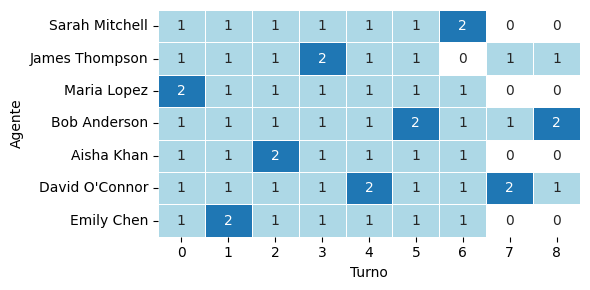

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

agent_names = [agent.name for agent in agents]

# Crear matrices
engagement_matrix = []
active_matrix = []

for i, comprometedores in enumerate(engagement_log):
    row = []
    active_row = []
    for name in agent_names:
        row.append(1 if name in comprometedores else 0)
        active_row.append(2 if name == intervenciones[i] else 0)
    engagement_matrix.append(row)
    active_matrix.append(active_row)

# Fusionar matrices
combined_matrix = np.where(np.array(active_matrix) == 2, 2, engagement_matrix)
df = pd.DataFrame(combined_matrix.T, index=agent_names)

# Heatmap
plt.figure(figsize=(6, 3))
sns.heatmap(df, annot=True, cmap=sns.color_palette(["#ffffff", "#add8e6", "#1f77b4"]),
            cbar=False, linewidths=0.5, xticklabels=range(len(intervenciones)), yticklabels=agent_names)
plt.xlabel("Turno")
plt.ylabel("Agente")
plt.tight_layout()
plt.show()


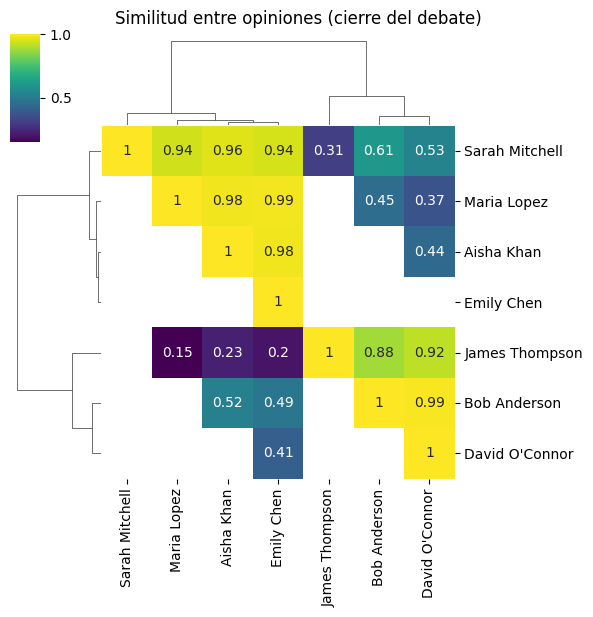

In [21]:
last_opinions = []
for agent in agents:
  emb = sbert.encode(agent.last_opinion)
  last_opinions.append(emb)
 # query for diversity, buscar consenso

last_opinions = np.array(last_opinions)
sim_matrix = cosine_similarity(last_opinions)

sns.clustermap(sim_matrix, annot=True, cmap="viridis", figsize=(6, 6),
               xticklabels=agent_names, yticklabels=agent_names,
               mask=np.tril(np.ones_like(sim_matrix, dtype=bool), -1))

plt.suptitle("Similitud entre opiniones (cierre del debate)", y=1.02)
plt.show()

In [22]:
n = 7
total_similarity = np.sum(sim_matrix) - np.trace(sim_matrix)  # Exclude diagonal elements
num_pairs = n * (n - 1)  # Total number of comparisons (excluding self-pairs)

average_similarity = total_similarity / num_pairs

average_similarity

0.6332009633382162

### Votando!

In [23]:
ballot = agent.voting(topic = agent.topic, context = agent.mem_to_str(),  opinion = agent.last_opinion)

## Votación

In [24]:
razones = []

Yea = 0
Nay = 0
for agent in agents:
  print(agent.name)
  voto, razon = agent.vote()
  razones.append(agent.name + ': '+ razon)
  if voto:
    Yea+=1
  else:
    Nay+=1

  print(voto)

  print('\n-------------------\n')


print(f'Yea: {Yea}')
print(f'Nay: {Nay}')

Sarah Mitchell
True

-------------------

James Thompson
False

-------------------

Maria Lopez
True

-------------------

Bob Anderson
False

-------------------

Aisha Khan
True

-------------------

David O'Connor
False

-------------------

Emily Chen
True

-------------------

Yea: 4
Nay: 3


In [25]:
for razon in razones:
  print(razon,'\n')

Sarah Mitchell: The opinion presented supports the ambitious goal of transitioning 50% of energy production to renewable sources by 2030, emphasizing the urgency of climate change and the necessity for bold action. The reasoning highlights the importance of investing in renewable infrastructure, fostering public-private partnerships, and implementing economic incentives to stimulate innovation. It also addresses the need for job creation in the renewable sector while ensuring support for workers in traditional energy sectors. This perspective aligns with the proposal's objectives and recognizes the potential benefits of a comprehensive approach to renewable energy. Therefore, the opinion is in favor of the proposal. 

James Thompson: The opinion expressed highlights significant concerns regarding the feasibility and potential economic impact of the proposed nationwide renewable energy policy. The skepticism towards the ambitious goal of transitioning 50% of energy production to renewab

## Dinámica del debate

In [26]:
from transformers import pipeline

# Carga el pipeline (puedes cambiar el modelo por uno multilingüe si es necesario)
sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

sentimientos = []
scores = []

for opinion in opiniones:
    result = sentiment_analyzer(opinion)[0]
    sentimientos.append(result["label"])
    scores.append(result["score"])


Device set to use cuda:0


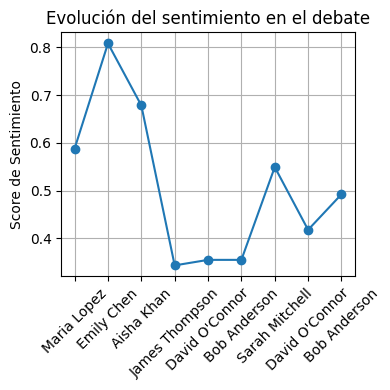

In [27]:
plt.figure(figsize=(4, 4))
plt.plot(scores, marker='o')
plt.xticks(range(len(intervenciones)), intervenciones, rotation=45)
plt.title("Evolución del sentimiento en el debate")
plt.ylabel("Score de Sentimiento")
plt.grid(True)
plt.tight_layout()
plt.show()


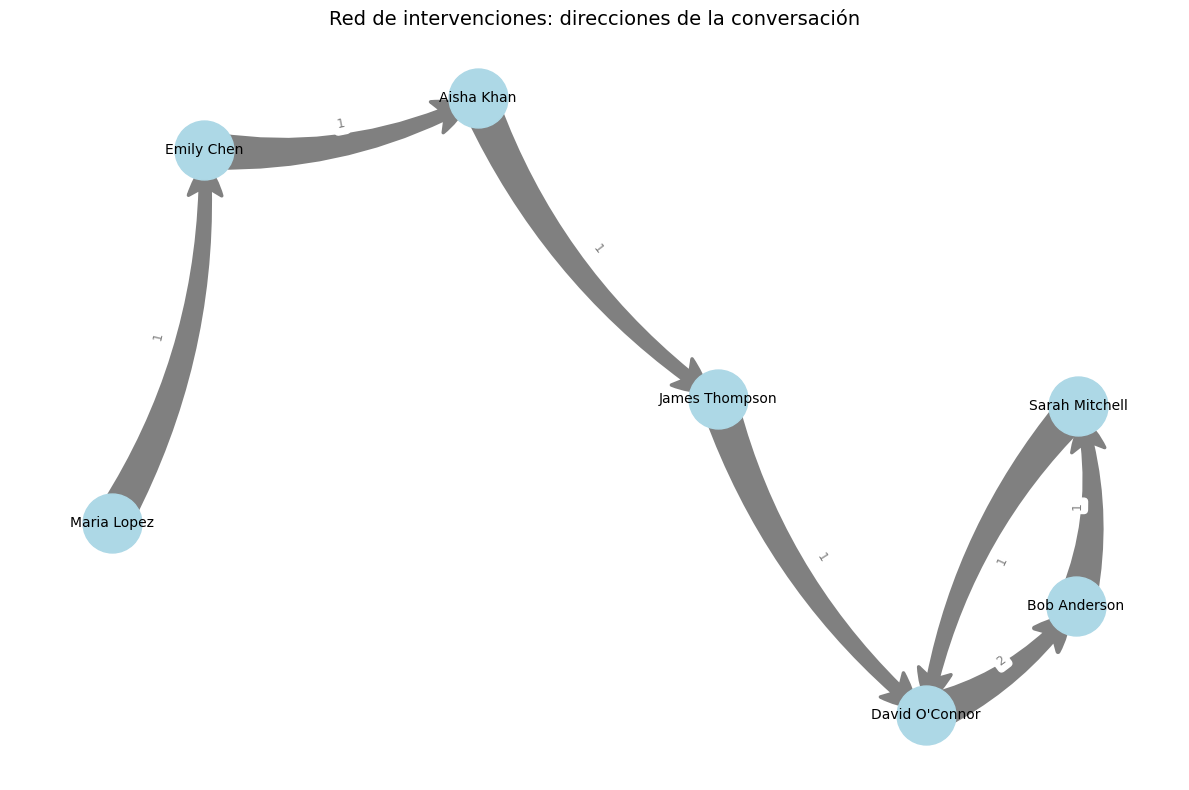

In [36]:
import networkx as nx
from collections import Counter


# Crear grafo dirigido
G = nx.DiGraph()

# Contar transiciones entre agentes
edges = [(intervenciones[i], intervenciones[i + 1]) for i in range(len(intervenciones) - 1)]
transition_counts = Counter(edges)

# Agregar nodos y aristas con pesos
for (src, tgt), weight in transition_counts.items():
    G.add_edge(src, tgt, weight=weight)

# Posicionamiento
pos = nx.spring_layout(G, seed=42)

# Dibujar nodos y etiquetas
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1800)
nx.draw_networkx_labels(G, pos, font_size=10)

# Dibujar aristas dirigidas con flechas
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]

nx.draw_networkx_edges(
    G, pos, edgelist=edges,
    width=[1.5 + w for w in weights],  # grosor proporcional al peso
    edge_color='gray',
    arrowstyle='fancy',
    arrowsize=60,
    connectionstyle='arc3,rad=0.15'  # leve curvatura para claridad
)

# Etiquetas de los pesos en las aristas
edge_labels = {(u, v): G[u][v]['weight'] for u, v in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='gray', font_size=9)

plt.title("Red de intervenciones: direcciones de la conversación", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


## Análisis del Bug: Primera Intervención

**Problema identificado**: Los agentes comparan con `self.last_opinion = ''` en la primera ronda, causando que todos quieran participar inicialmente pero luego el debate se vuelva poco dinámico.

### Posibles soluciones:

In [ ]:
# Verificar el comportamiento con string vacío
print("Probando similitud con string vacío:")
test_opinion = "I think we should increase public spending on education"
empty_similarity = sbert.similarity(sbert.encode(test_opinion), sbert.encode('')).numpy()[0][0]
print(f"Similitud entre opinión real y string vacío: {empty_similarity}")
print(f"¿Se compromete? {empty_similarity < 0.3 or empty_similarity > 0.75}")

# Simulación de primera ronda
print("\n" + "="*50)
print("SIMULACIÓN: ¿Qué pasa en la primera ronda?")
print("="*50)

# Simular que todos los agentes tienen last_opinion = ''
for i, agent in enumerate(agents):
    # Resetear para simular estado inicial
    original_opinion = agent.last_opinion
    agent.last_opinion = ''  # Estado inicial
    
    # Simular reacción a una opinión de prueba
    would_engage = agent.evaluate(test_opinion)
    print(f"{agent.name}: ¿Se compromete? {would_engage}")
    
    # Restaurar estado original
    agent.last_opinion = original_opinion

### Propuesta de Mejora: Generar "Opinión 0"

Una solución más elegante sería que cada agente genere una **opinión inicial** usando exactamente el mismo mecanismo que usa para opiniones posteriores, pero con contexto vacío.

In [ ]:
# ANÁLISIS: ¿Qué usa el agente para generar opiniones?
print("SISTEMA ACTUAL DE GENERACIÓN DE OPINIONES:")
print("="*50)
print("El método forward() usa:")
print("1. topic: El tema del debate")
print("2. context: Memoria de últimas 3 opiniones escuchadas (self.mem_to_str())")
print("3. your_background: El perfil/stance del agente")
print("\nFórmula DSPy: 'topic, context, your_background -> opinion'\n")

# Verificar qué tienen los agentes como background
print("BACKGROUNDS DE LOS AGENTES:")
print("-" * 30)
for i, agent in enumerate(agents[:3]):  # Solo primeros 3 para ver
    print(f"{agent.name}:")
    print(f"  Background: {agent.background[:100]}...")  # Solo primeros 100 chars
    print(f"  Memoria actual: '{agent.mem_to_str().strip()}'")
    print()

print("\nPROPUESTA: Generar 'Opinión 0'")
print("="*40)
print("Modificar __init__ para generar opinión inicial:")
print("- topic: ✓ (ya disponible)")
print("- context: '' (memoria vacía al inicio)")  
print("- your_background: ✓ (ya disponible)")
print("\nEsto daría una opinión baseline consistente con el sistema actual.")

In [ ]:
# IMPLEMENTACIÓN: Clase PoliAgent Mejorada
class ImprovedPoliAgent(dspy.Module):
    def __init__(self, name, background, topic, number):
        self.id = number-1
        self.similarity_model = sbert
        self.topic = topic
        self.name = name
        self.background = background
        self.memory = FixedMemory(3)
        self.respond = dspy.Predict('topic, context, your_background -> opinion')
        self.voting = dspy.ChainOfThought('topic, context, opinion -> vote:bool')
        
        # 🚀 MEJORA: Generar opinión inicial usando el mismo sistema
        self.last_opinion = self._generate_initial_opinion()
        
    def _generate_initial_opinion(self):
        """Genera la opinión baseline del agente usando el sistema estándar"""
        context = ''  # Memoria vacía al inicio
        resp = self.respond(topic=self.topic, context=context, your_background=self.background)
        return resp.opinion
        
    def mem_to_str(self):
        mem = list(self.memory.queue)
        text = ''
        for opinion in mem:
            text += ' ' + opinion + '\n'
        return text

    def forward(self):
        topic = self.topic
        context = self.mem_to_str()
        background = self.background
        resp = self.respond(topic=topic, context=context, your_background=background)
        self.last_opinion = resp.opinion

    def similarity_score(self, text1, text2):
        embd1 = self.similarity_model.encode(text1)
        embd2 = self.similarity_model.encode(text2)
        return self.similarity_model.similarity(embd1, embd2).numpy()[0][0]

    def evaluate(self, opinion):
        sim_score = self.similarity_score(opinion, self.last_opinion)
        if sim_score < 0.3 or sim_score > 0.75:
            return True
        else:
            return False

    def think(self, opinion):
        if self.evaluate(opinion):
            wanna_talk = True
            self.memory.enqueue(opinion)
        else:
            wanna_talk = False
        return wanna_talk

    def talk(self):
        self.forward()
        return self.last_opinion

    def vote(self):
        context = self.mem_to_str()
        vote = self.voting(topic=self.topic, context=context, opinion=self.last_opinion)
        return vote.vote, vote.reasoning

print("✅ Clase ImprovedPoliAgent definida con generación de 'opinión 0'")

### Comparación: Original vs Mejorado

Ahora comparemos el comportamiento del sistema original vs el mejorado:

In [ ]:
# DEMO: Crear un agente mejorado para comparar
print("CREANDO AGENTE DE PRUEBA CON LA MEJORA...")
print("="*50)

# Usar el primer perfil para la prueba
test_agent_improved = ImprovedPoliAgent('Test Agent', profiles[0], topic, 99)

print(f"✅ Agente creado: {test_agent_improved.name}")
print(f"📝 Opinión inicial generada:")
print(f"   '{test_agent_improved.last_opinion[:150]}...'")
print()

# Comparar con agente original (que tiene string vacío)
original_agent = agents[0]  # Sarah Mitchell
print(f"🔍 COMPARACIÓN:")
print(f"Original (Sarah): last_opinion = '{original_agent.last_opinion}'")
print(f"Mejorado (Test):  last_opinion = '{test_agent_improved.last_opinion[:50]}...'")
print()

# Test de engagement con una opinión de prueba
test_opinion = "We should prioritize environmental protection over economic growth"
print(f"💭 Opinión de prueba: '{test_opinion}'")
print()

# Simular reacción
original_engage = original_agent.think(test_opinion)  # Con string vacío
improved_engage = test_agent_improved.think(test_opinion)  # Con opinión inicial

print(f"🎯 RESULTADOS DE ENGAGEMENT:")
print(f"   Original: {original_engage} (comparó con string vacío)")
print(f"   Mejorado: {improved_engage} (comparó con opinión inicial)")

# Mostrar similitudes para entender
if test_agent_improved.last_opinion != '':
    sim_improved = test_agent_improved.similarity_score(test_opinion, test_agent_improved.last_opinion)
    print(f"   Similitud mejorado: {sim_improved:.3f}")